# Demand Forecasting Using NeuralProphet

In this notebook, we develop a reference forecasting pipline using NeuralProphet. We use a univariate time series wihthout covariates.

In [3]:
import pathlib
import numpy as np
import pandas as pd
from tabulate import tabulate
import datetime

from neuralprophet import NeuralProphet

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-white')
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import platform
print(f'Python {platform.python_version()}')

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
WARNING - (py.warnings._showwarnmsg) - <ipython-input-3-928d615a4868>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')

  plt.style.use('seaborn-white')



Python 3.10.12


In [4]:
#
# Helper functions
#

# Print a dataset
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

# Highlight weekends on a time series chart
def highlight_weekends(ax, color='k', alpha=0.1):
    ax.set_ylim(*ax.get_ylim())
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)
    weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor=color, alpha=alpha)
    ax.set_xlim(xmin, xmax)

# Data Loading

We use a small dataset that mimics daily sales series for a retail chain. The dataset consists of 500 sales time series for 10 stores and 50 items (SKUs). Each series spans 5 years.

In [5]:
data_path = 'https://github.com/ikatsov/tensor-house-data/raw/master/time-series'
df = pd.read_csv(f'{data_path}/store-item-sales.csv.zip', compression='zip', parse_dates=['date'], index_col='date')
df.sort_values(['date'], axis=0, ascending=[True], inplace=True)

print_df(df)
print(f'Unique stores: {df.store.nunique()}, unique items: {df.item.nunique()}')

+---------------------+---------+--------+---------+
| date                |   store |   item |   sales |
|---------------------+---------+--------+---------|
| 2013-01-01 00:00:00 |       1 |      1 |      13 |
| 2013-01-01 00:00:00 |       7 |     12 |      26 |
| 2013-01-01 00:00:00 |       7 |     46 |      27 |
| 2013-01-01 00:00:00 |       8 |     12 |      54 |
| 2013-01-01 00:00:00 |       9 |     12 |      35 |
| 2013-01-01 00:00:00 |      10 |     12 |      41 |
| 2013-01-01 00:00:00 |       6 |     46 |      23 |
| 2013-01-01 00:00:00 |       1 |     13 |      37 |
| 2013-01-01 00:00:00 |       2 |     13 |      51 |
| 2013-01-01 00:00:00 |       5 |     46 |      20 |
+---------------------+---------+--------+---------+
913000 rows x 3 columns
Unique stores: 10, unique items: 50


In [6]:
data = pd.read_csv('yahoo_stock.csv', parse_dates=['Date'], index_col='Date')
start_date = "2015-12-01"
end_date = "2020-11-20"
data_f = data['Close'][start_date:end_date]
# data_f.head()
data_s = data_f.resample('MS').mean()  # Or use .sum()/.first()/.last() based on your needs

# Display the resulting Series
print(data_s.head())

Date
2015-12-01    2051.352913
2016-01-01    1927.887408
2016-02-01    1902.567938
2016-03-01    2023.688059
2016-04-01    2074.564001
Freq: MS, Name: Close, dtype: float64


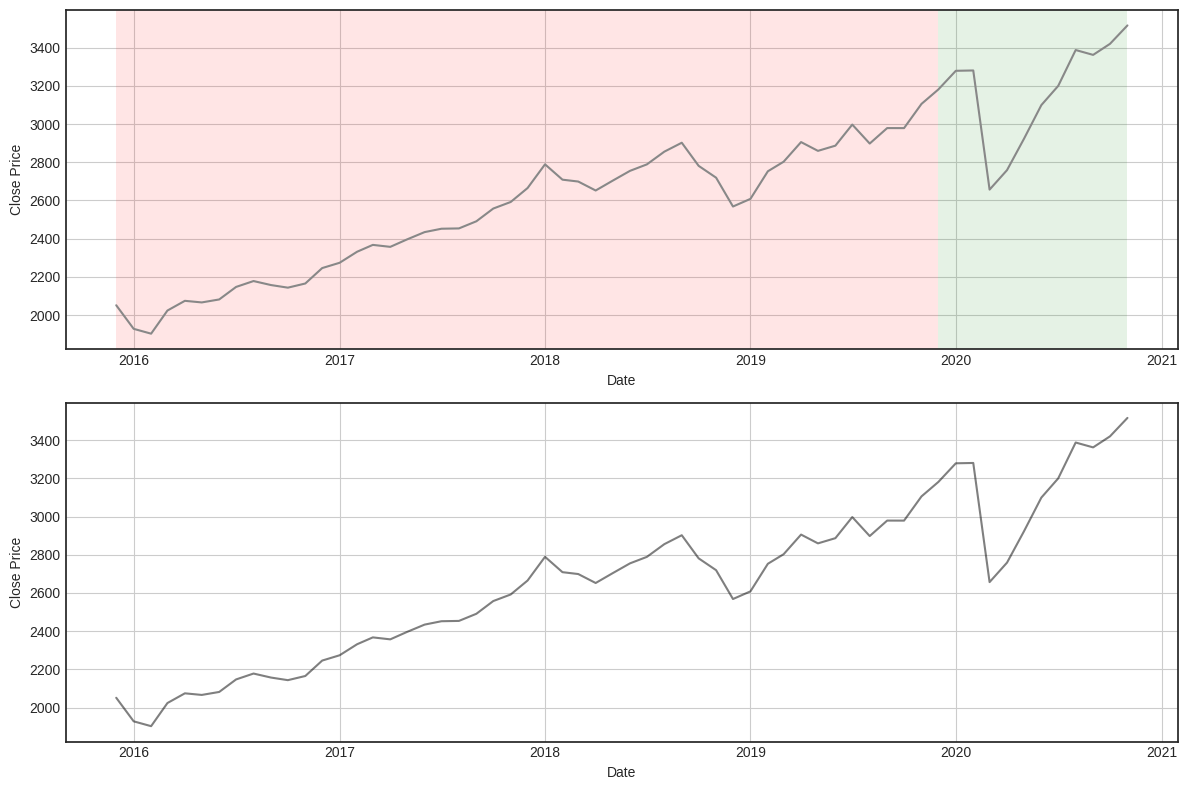

In [7]:
# Set the train/test split date
prediction_length = 12  # Example: 12 months for test data
dates = data_s.index.unique().sort_values()
split_date = dates[-prediction_length]

# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Full date range
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Close Price')
ax[0].grid(True)
ax[0].axvspan(dates[0], split_date, facecolor='r', alpha=0.1)
ax[0].axvspan(split_date, dates[-1], facecolor='g', alpha=0.1)
ax[0].plot(data_s.index, data_s, c='#888888')

# Last 100 data points
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Close Price')
ax[1].plot(data_s[-100:].index, data_s[-100:], c='k', alpha=0.5)
ax[1].grid(True)

plt.tight_layout()
plt.show()

# NeuralProphet Training and Evaluation

In [8]:
df_prophet = data_s.reset_index()
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

# Set train/test split
prediction_length = 12  # Example: 12 months for test data
df_train, df_test = df_prophet[:-prediction_length], df_prophet[-prediction_length:]

# Initialize and fit NeuralProphet model
m = NeuralProphet(quantiles=[0.01, 0.10, 0.90, 0.99])
metrics = m.fit(df_train, freq='MS')

# Optionally, you can make predictions and evaluate the model
future = df_prophet[-prediction_length:].copy()
forecast = m.predict(future)

# Visualize predictions (optional)
import matplotlib.pyplot as plt

fig = m.plot(forecast)
plt.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.917]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.


Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()

  ds = fcst["ds"].dt.to_pydatetime()



INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.917]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.917]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




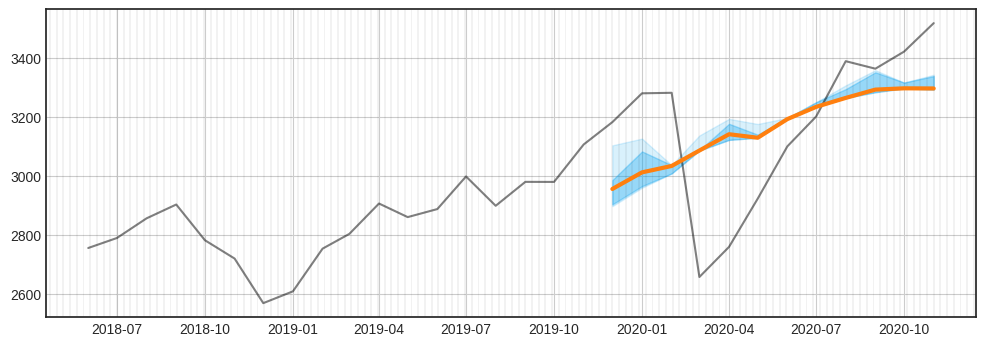

In [9]:
forecast_past = m.predict(df_train)
forecast_future = m.predict(df_test)

fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(df_prophet['ds'][-5 * prediction_length // 2:], df_prophet['y'][-5*prediction_length // 2:], color='k', alpha=0.5)
ax.plot(forecast_future['ds'], forecast_future['yhat1'], color='C1', linewidth=3)
ax.fill_between(forecast_future['ds'], forecast_future['yhat1 10.0%'], forecast_future['yhat1 90.0%'], color='#00a1f1', alpha=0.3)
ax.fill_between(forecast_future['ds'], forecast_future['yhat1 1.0%'], forecast_future['yhat1 99.0%'], color='#00a1f1', alpha=0.15)
ax.grid(True)
highlight_weekends(ax, alpha=0.05)

fig_comp = m.plot_components(forecast_past)